<h2>Outline:</h2>

*   Necessary installation and imports
*   Using the 3 CNOTS filter
*   Using sickit image rescale



<h2>1. Necessary installation and imports</h2>

In [8]:
!pip install tensorflow

In [5]:
!pip install keras

In [9]:
!pip install pennylane --upgrade

In [1]:
import pennylane as qml
from pennylane import numpy as np
import keras
from keras.models import Sequential,Model

from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
from sklearn import metrics

import matplotlib.pyplot as plt
import time

2024-06-13 15:59:46.286164: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-13 15:59:46.343251: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-13 15:59:47.389907: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import json

import sys
sys.path.append('../scripts/')

from Filters import *
from Data_load import data_load
from utils import *


In [3]:

## Import the images
data = data_load()
train_images, train_labels, test_images, test_labels = data.data_mnist()

6000


In [4]:
print("shape of train images", train_images[0].shape)
print("shape of test images", test_images[0].shape)

shape of train images (28, 28, 1)
shape of test images (28, 28, 1)


In [5]:
print("length of train images", len(train_images))
print("length of test images", len(test_images))

length of train images 6000
length of test images 1000


<h2>2. Using the 3 CNOTs filter</h2>

In [6]:
# This function returns the modified dataset
# It is a script to get a dataset of 2 labels only
def trainTestData(train_images, train_labels, test_images, test_labels, label1, label2, n_train, n_test):
    n_train_images, n_train_labels, n_test_images, n_test_labels = [], [], [], []
    i = 0
    while (n_train > 0 and i < len(train_images)):
        if train_labels[i] == label1:
            n_train_images.append(train_images[i])
            n_train_labels.append(label1)
            n_train -= 1
        if train_labels[i] == label2:
            n_train_images.append(train_images[i])
            n_train_labels.append(label2)
            n_train -= 1
        i = i+1
    i = 0
    while(n_test>0 and i < len(test_images)):
        if test_labels[i] == label1:
            n_test_images.append(test_images[i])
            n_test_labels.append(label1)
            n_test -= 1
        if test_labels[i] == label2:
            n_test_images.append(test_images[i])
            n_test_labels.append(label2)
            n_test -= 1
        i = i+1
    return n_train_images, n_train_labels, n_test_images, n_test_labels

In [7]:
# getting a dataset of numbers 3 and 5 with train dataset of 80 and test dataset of 35
train_images, train_labels, test_images, test_labels = trainTestData(train_images, train_labels, test_images, test_labels, 3, 5, len(train_images), len(test_images))

In [8]:
# this functions makes the train dataset balanced
# number of images for number 3 same as that for number 5
def balanceDataSet(BAS, train_labels):
    new_train_images_3 = []
    new_train_images_5 = []

    new_train_labels_3 = []
    new_train_labels_5 = []

    for i in range(len(BAS)):
      if train_labels[i] == 3:
        new_train_images_3.append(BAS[i])
        new_train_labels_3.append(3)
      else:
        new_train_images_5.append(BAS[i])
        new_train_labels_5.append(5)
        
    if len(new_train_images_3) > len(new_train_images_5):
      return new_train_images_3[0:len(new_train_images_5)] + new_train_images_5[0:len(new_train_images_5)], new_train_labels_3[0:len(new_train_images_5)] + new_train_labels_5[0:len(new_train_images_5)]
    else: 
      return new_train_images_3[0:len(new_train_images_3)] + new_train_images_5[0:len(new_train_images_3)], new_train_labels_3[0:len(new_train_images_3)] + new_train_labels_5[0:len(new_train_images_3)]

In [9]:
train_images, train_labels = balanceDataSet(train_images, train_labels)
# saving the dataset for using in the other part about classical resizing using sickit image, skimage
# to have a fair comparison of performance
org_train_images, org_train_labels, org_test_images, org_test_labels = train_images, train_labels, test_images, test_labels

In [10]:
print("length of train images", len(train_images))
print("length of test images", len(test_images))

length of train images 1028
length of test images 194


In [11]:
# Applying the quantum filter for the first time
# (28, 28) to (14, 14) image
start_time = time.time()

filtered_train_images = apply_filter(train_images, 6, data.n_channels, data.n_layers, True)
filtered_test_images = apply_filter(test_images, 6, data.n_channels, data.n_layers, True)

end_time = time.time()

time_taken = end_time - start_time

print(time_taken/60, " minutes")

fitlered pre-processing of images, with type = 6
fitlered pre-processing of images, with type = 6
8.706002533435822  minutes


In [12]:
train_images = filtered_train_images
test_images = filtered_test_images

In [13]:
print("shape of train images", filtered_train_images[0].shape)
print("shape of test images", filtered_test_images[0].shape)

shape of train images (14, 14, 1)
shape of test images (14, 14, 1)


In [14]:
# Applying the quantum filter for the second time
# (14, 14) to (7,7) image
start_time = time.time()

filtered_train_images = apply_filter(train_images, 6, data.n_channels, data.n_layers, True)
filtered_test_images = apply_filter(test_images, 6, data.n_channels, data.n_layers, True)

end_time = time.time()

time_taken = end_time - start_time

print(time_taken/60, " minutes")

fitlered pre-processing of images, with type = 6
fitlered pre-processing of images, with type = 6
2.1089615782101947  minutes


In [15]:
train_images = filtered_train_images
test_images = filtered_test_images

In [16]:
print("shape of train images", train_images[0].shape)
print("shape of test images", test_images[0].shape)

shape of train images (7, 7, 1)
shape of test images (7, 7, 1)


In [18]:
test_images[3]
# The following matrix contains values between -1 and 1
# so simply we will take the values less than 0 to be 0 and greater than 0 to be 1
# but when rescaling with skimage in the next part we get values between 0 and 1
# so we put in the next part the values less than 0.5 as 0 and the ones greater than 0.5 as 1

tensor([[[ 1.        ],
         [ 1.        ],
         [ 1.        ],
         [ 1.        ],
         [ 1.        ],
         [ 1.        ],
         [ 1.        ]],

        [[ 1.        ],
         [ 1.        ],
         [-0.91899874],
         [ 0.02928895],
         [-0.30687935],
         [ 0.11526982],
         [-0.77833392]],

        [[ 1.        ],
         [ 1.        ],
         [-0.06152208],
         [ 0.47779281],
         [ 1.        ],
         [ 0.95491717],
         [ 1.        ]],

        [[ 1.        ],
         [ 1.        ],
         [-0.23134438],
         [-0.38260291],
         [-0.29064794],
         [ 1.        ],
         [ 1.        ]],

        [[ 1.        ],
         [ 1.        ],
         [-0.52414954],
         [ 0.27590582],
         [-0.04737667],
         [ 1.        ],
         [ 1.        ]],

        [[ 1.        ],
         [-0.91910783],
         [ 0.82081461],
         [-0.00316614],
         [-0.81208445],
         [ 1.        ],
      

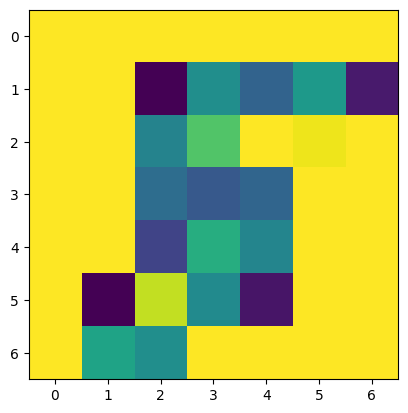

In [17]:
plt.imshow(test_images[3])
# just plotting the 7x7 image to get a sense of how it looks

In [18]:
# Function to replace the values less than middle by 0
# and the values greater than middle by 1
def zeroAndOne(train_images, test_images, middle):
    for img in train_images:
        for i in range(img.shape[0]):
            for j in range(img.shape[1]):
                if img[i][j] < middle:
                    img[i][j] = 0
                else:
                    img[i][j] = 1
    for img in test_images:
        for i in range(img.shape[0]):
            for j in range(img.shape[1]):
                if img[i][j] < middle:
                    img[i][j] = 0
                else:
                    img[i][j] = 1

In [19]:
zeroAndOne(train_images, test_images, 0)

In [20]:
# function to perform max pooling using keras
def conv(train_images, test_images):

    new_train_images, new_test_images = [], []

    for img in train_images:
        img = np.reshape(img, [1, 7, 7, 1])
        max_pool_2d = keras.layers.MaxPooling2D(pool_size=(1, 1), strides=(2, 2), padding="valid")
        new_train_images.append(np.reshape(max_pool_2d(img), [4, 4]))

    for img in test_images:
        img = np.reshape(img, [1, 7, 7, 1])
        max_pool_2d = keras.layers.MaxPooling2D(pool_size=(1, 1), strides=(2, 2), padding="valid")
        new_test_images.append(np.reshape(max_pool_2d(img), [4, 4]))
    return new_train_images, new_test_images

In [21]:
train_images, test_images = conv(train_images, test_images)

2024-06-13 16:11:08.804701: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


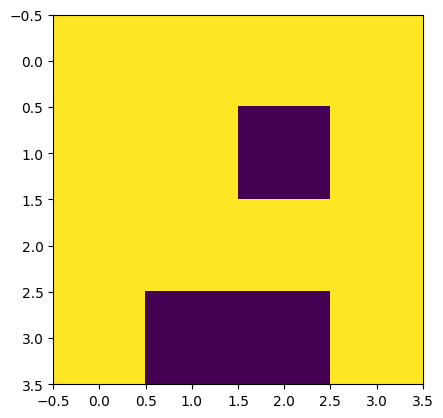

In [22]:
plt.imshow(test_images[5])

In [23]:
def block(weights, wires):
    qml.RY(weights[0], wires=wires[0])
    qml.RY(weights[1], wires=wires[1])
    qml.CNOT(wires=wires)

In [24]:
# BAS is the list that will contain the images for encoding in the quantum circuit
# flatten is used to transfoem from (4,4) into (16,)
BAS = []
for img in train_images:
    BAS.append(img.flatten())

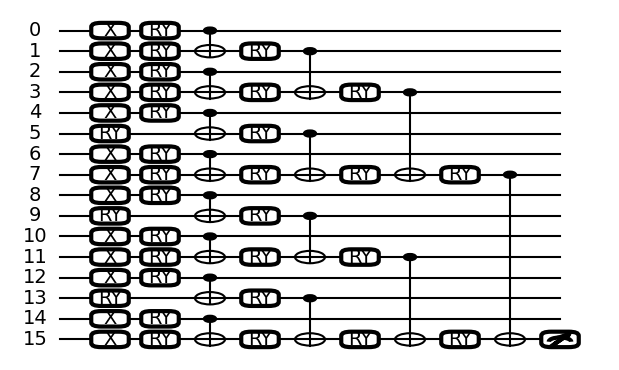

In [25]:
dev = qml.device("default.qubit", wires=16)


@qml.qnode(dev)
def circuit(image, template_weights):
    qml.BasisStatePreparation(image, wires=range(16))
    qml.TTN(
        wires=range(16),
        n_block_wires=2,
        block=block,
        n_params_block=2,
        template_weights=template_weights,
    )
    return qml.expval(qml.PauliZ(wires=15))

weights = np.random.random(size=[15, 2])
fig, ax = qml.draw_mpl(circuit, expansion_strategy="device")(BAS[0], weights)
fig.set_size_inches((6, 3.5))

In [26]:
print("length of train images", len(train_images))
print("length of test images", len(test_images))

length of train images 1028
length of test images 194


In [27]:
# defining the cost function
def costfunc(params):
    cost = 0
    for i in range(len(BAS)):
        if i < len(BAS) / 2:
            cost += circuit(BAS[i], params)
        else:
            cost -= circuit(BAS[i], params)
    return cost

In [28]:
# training the circuit parameters
# storing the params in x2 to use the same initial parameters in part 3
x2 = np.random.random(size=[15, 2], requires_grad=True)
params = x2[:]
optimizer = qml.GradientDescentOptimizer(stepsize=0.01)

for k in range(71):
    if k % 5 == 0:
        print(f"Step {k}, cost: {costfunc(params)}")
    params = optimizer.step(costfunc, params)

Step 0, cost: 0.6640734255280194
Step 5, cost: -35.23656569494744
Step 10, cost: -0.23166445426758886
Step 15, cost: 78.78331318111381
Step 20, cost: -82.73957160370018
Step 25, cost: 19.220183715214414
Step 30, cost: 70.77314427059041
Step 35, cost: -36.6692773431315
Step 40, cost: -34.98829078483345
Step 45, cost: 61.11680152963429
Step 50, cost: -132.85034704561056
Step 55, cost: 55.65981966469592
Step 60, cost: -171.5301335678538
Step 65, cost: -176.83147396286552
Step 70, cost: -101.59732154710264


In [29]:
# The list that will hold the test images for testing accuracy
BAS_test = []
for img in test_images:
  BAS_test.append(img.flatten())

In [30]:
values, counts = np.unique(test_labels, return_counts=True)
print(values, "name of labels in our dataset, here they are 3 and 5")
print(counts, "how much we have in our test dataset from each of the above numbers 3 and 5")

[3 5] name of labels in our dataset, here they are 3 and 5
[107  87] how much we have in our test dataset from each of the above numbers 3 and 5


In [31]:
i = 0
train_correct = 0
for img in BAS:
  if circuit(img,params) < 0 and train_labels[i] == 3:
    train_correct += 1
  elif circuit(img,params) > 0 and train_labels[i] == 5:
    train_correct += 1
  i += 1
print("training accuracy: 60 images, 30 for letter 3 and 30 for letter 5")
print(100*train_correct/len(BAS),"%")

training accuracy: 60 images, 30 for letter 3 and 30 for letter 5
59.143968871595334 %


In [32]:
predicted = []
i = 0
test_correct = 0
for img in BAS_test:
  if circuit(img.flatten(),params) < 0:
    predicted.append(3)
  if circuit(img.flatten(),params) > 0:
    predicted.append(5)
  if circuit(img.flatten(),params) < 0 and test_labels[i] == 3:
    test_correct += 1
  elif circuit(img.flatten(),params) > 0 and test_labels[i] == 5:
    test_correct += 1
  i += 1
print("testing accuracy: 35 images, 15 for letter 3 and 20 for letter 5")
print(100*test_correct/len(BAS_test),"%")

testing accuracy: 35 images, 15 for letter 3 and 20 for letter 5
57.7319587628866 %


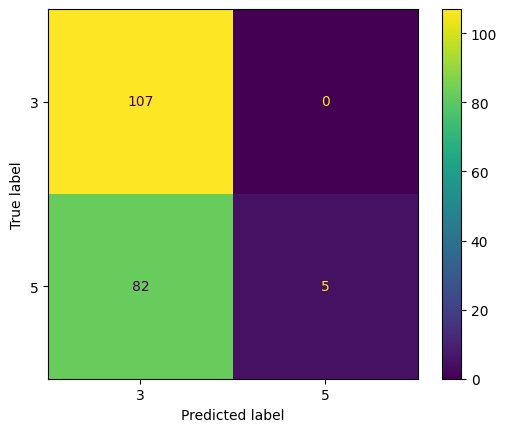

In [33]:
actual = np.array(test_labels)
predicted = np.array(predicted)

confusion_matrix = metrics.confusion_matrix(actual, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [3, 5])

cm_display.plot()
plt.show()

<h2>3. Using classical filter:</h2>



1.   Getting the saved original balanced dataset
2.   Changing the shape and size of the train and test dataset from (28, 28) to (16,)
3.   Defining the cost function
4.   Training using optimizer, stepsize = 0.01, iterations = 70
5.   Finding the train and test accuracy



In [34]:
#using original saved images balanced dataset for fair comparison
train_images, train_labels, test_images, test_labels = org_train_images, org_train_labels, org_test_images, org_test_labels

In [35]:
print("shape of train images", BAS[0].shape)
print("shape of test images", BAS_test[0].shape)

shape of train images (16,)
shape of test images (16,)


In [36]:
# changing the shape and size of the train images and storing in BAS
BAS = []
for img in train_images:
    # using sickit image to rescale to (4,4)
    img = rescale(img, 1/7, anti_aliasing=False)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if img[i][j] < 0.5:
                img[i][j] = 0
            else:
                img[i][j] = 1
    # flatten to change shape from (4,4) to (16,) to be able to use 16 qubits and encode the circuit
    BAS.append(img.flatten())

In [37]:
# rescale test images and store the new modified images in BAS_test
BAS_test = []
for img in test_images:
    img = rescale(img, 1/7, anti_aliasing=False)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if img[i][j] < 0.5:
                img[i][j] = 0
            else:
                img[i][j] = 1
    # flatten to change shape from (4,4) to (16,) to be able to use 16 qubits and encode the circuit
    BAS_test.append(img.flatten())

In [38]:
print("length of train images", len(BAS))
print("length of test images", len(test_images))

length of train images 1028
length of test images 194


In [39]:
print("shape of train images", BAS[0].shape)
print("shape of test images", BAS_test[0].shape)

shape of train images (16,)
shape of test images (16,)


In [40]:
# defining the cost function
def costfunc(params):
    cost = 0
    for i in range(len(BAS)):
        if i < len(BAS) / 2:
            cost += circuit(BAS[i], params)
        else:
            cost -= circuit(BAS[i], params)
    return cost

In [41]:
# training with the optimizer using the same initial saved parameters for fair comparison
params = x2[:]
optimizer = qml.GradientDescentOptimizer(stepsize=0.01)

for k in range(71):
    if k % 5 == 0:
        print(f"Step {k}, cost: {costfunc(params)}")
    params = optimizer.step(costfunc, params)

Step 0, cost: -71.646274058507
Step 5, cost: -348.0704837405568
Step 10, cost: -16.967618919825412
Step 15, cost: 1.0043859412029983
Step 20, cost: 57.89678934953895
Step 25, cost: 33.10949412765815
Step 30, cost: -10.762029604556789
Step 35, cost: -263.65595425473686
Step 40, cost: -59.20782353213906
Step 45, cost: -19.579288463764343
Step 50, cost: -63.312901743923504
Step 55, cost: -61.695231868176
Step 60, cost: -17.81632852437677
Step 65, cost: 27.712538802864
Step 70, cost: -259.14247780999557


In [42]:
i = 0
train_correct = 0
for img in BAS:
  if circuit(img,params) < 0 and train_labels[i] == 3:
    train_correct += 1
  elif circuit(img,params) > 0 and train_labels[i] == 5:
    train_correct += 1
  i += 1
print("training accuracy(2): 60 images, 30 for letter 3 and 30 for letter 5")
print(100*train_correct/len(BAS),"%")

training accuracy(2): 60 images, 30 for letter 3 and 30 for letter 5
30.93385214007782 %


In [43]:
predicted = []
i = 0
test_correct = 0
for img in BAS_test:
  if circuit(img.flatten(),params) < 0:
    predicted.append(3)
  if circuit(img.flatten(),params) > 0:
    predicted.append(5)
  if circuit(img,params) < 0 and test_labels[i] == 3:
    test_correct += 1
  elif circuit(img,params) > 0 and test_labels[i] == 5:
    test_correct += 1
  i += 1
print("testing accuracy(2): 35 images, 15 for letter 3 and 20 for letter 5")
print(100*test_correct/len(BAS_test),"%")

testing accuracy(2): 35 images, 15 for letter 3 and 20 for letter 5
33.50515463917526 %


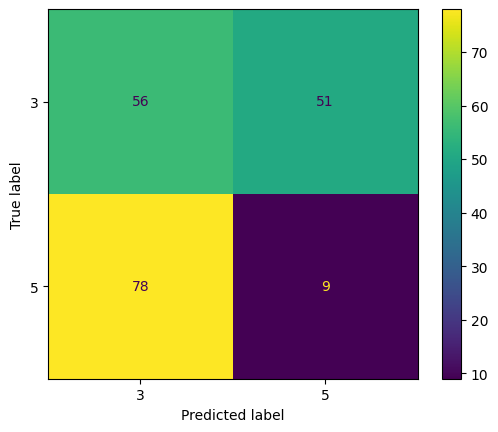

In [44]:
actual = np.array(test_labels)
predicted = np.array(predicted)

confusion_matrix = metrics.confusion_matrix(actual, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [3, 5])

cm_display.plot()
plt.show()